### Choose reference image and contact points

Reference image name: 13544f09512952bbc9273c10871e1c3d_1rgb


<IPython.core.display.Javascript object>


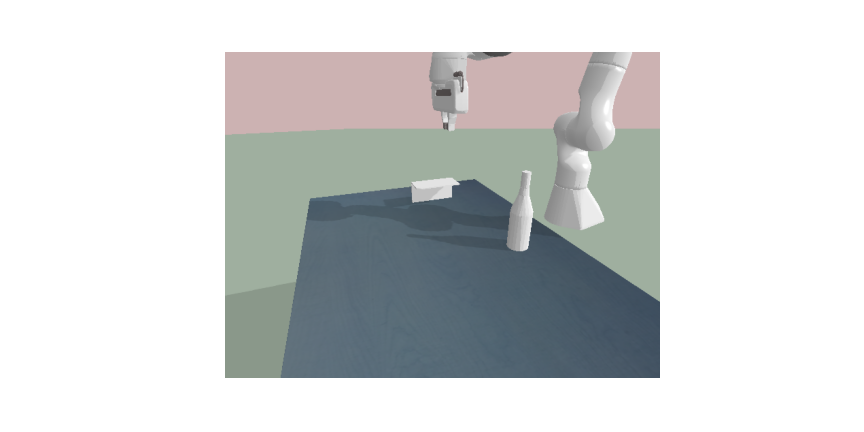

In [24]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2

np.random.seed(1)

root_path = 'pwarpc_generate_data'
split = 'train'
cls = 'bottle'
cam_id = 1

img_list = glob.glob(os.path.join(root_path,split,cls,f'*_{cam_id}rgb.png'))
ref_img_path = np.random.choice(img_list,1)[0]
ref_img_name = os.path.basename(ref_img_path).split('.')[0]
ref_mask_path = ref_img_path.replace('rgb','mask')

print('Reference image name:', ref_img_name)

ref_img = cv2.imread(ref_img_path, 1)[:, :, ::- 1]

%matplotlib notebook
fig = plt.figure(figsize=(8, 4))
plt.imshow(ref_img)
plt.axis('off')
plt.show()


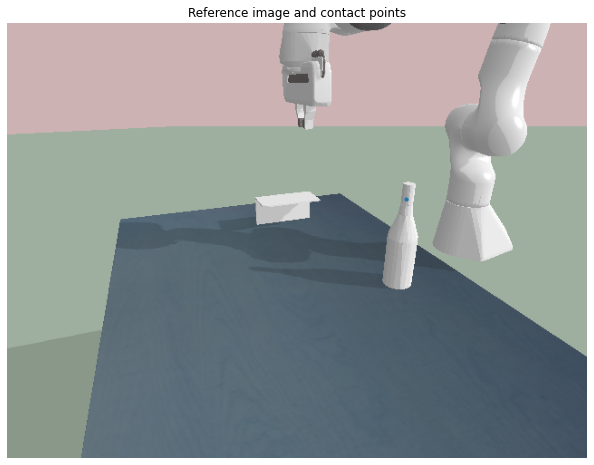

{'img_name': '13544f09512952bbc9273c10871e1c3d_1rgb', 'contact_pts': array([[440, 194]])}
Saved!


In [28]:
ref_contact_pts = np.array([[440,194]])

%matplotlib inline
fig = plt.figure(figsize=(16, 8))
plt.imshow(ref_img)
plt.scatter(ref_contact_pts[:,0],ref_contact_pts[:,1],s = 10)
plt.axis('off')
plt.title('Reference image and contact points')
plt.show()

ref_info = dict()
ref_info['img_name'] = ref_img_name
ref_info['contact_pts'] = ref_contact_pts
print(ref_info)

save_dir = os.path.join(root_path,cls+'_pts')
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
save_path = os.path.join(save_dir,'ref_info.mat')
sio.savemat(save_path, ref_info)
print('Saved!')

 ### Some functions prepared for matching


In [3]:
model = 'PWarpCSFNet_SS'
pretrained = 'pfpascal'

In [18]:
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
import cv2
from model_selection import select_model
from utils_flow.util_optical_flow import flow_to_image
from utils_flow.visualization_utils import overlay_semantic_mask,make_sparse_matching_plot
from test_models import crop_image_according_to_mask, boolean_string,pad_to_same_shape
import numpy as np
from validation.test_parser import define_model_parser, define_pdcnet_parser
from validation.utils import matches_from_flow
import argparse
import torch

crop_image_from_mask = crop_image_according_to_mask

def test_model_on_image_pair(args, query_image, reference_image,contact_pixels = None, visualize = True):
    with torch.no_grad():
        network, estimate_uncertainty = select_model(
            args.model, args.pre_trained_model, args, args.optim_iter, local_optim_iter,
            path_to_pre_trained_models=args.path_to_pre_trained_models)

        # save original ref image shape
        ref_image_shape = reference_image.shape[:2]

        # pad both images to the same size, to be processed by network
        query_image_, reference_image_ = pad_to_same_shape(query_image, reference_image)
        # convert numpy to torch tensor and put it in right format
        query_image_ = torch.from_numpy(query_image_).permute(2, 0, 1).unsqueeze(0)
        reference_image_ = torch.from_numpy(reference_image_).permute(2, 0, 1).unsqueeze(0)

        # ATTENTION, here source and target images are Torch tensors of size 1x3xHxW, without further pre-processing
        # specific pre-processing (/255 and rescaling) are done within the function.

        # pass both images to the network, it will pre-process the images and ouput the estimated flow
        # in dimension 1x2xHxW
        if estimate_uncertainty:
            if args.flipping_condition:
                raise NotImplementedError('No flipping condition with PDC-Net for now')

            estimated_flow, uncertainty_components = network.estimate_flow_and_confidence_map(query_image_,
                                                                                              reference_image_,
                                                                                              mode='channel_first')
            confidence_map = uncertainty_components['p_r'].squeeze().detach().cpu().numpy()
            confidence_map = confidence_map[:ref_image_shape[0], :ref_image_shape[1]]
        else:
            if args.flipping_condition and 'GLUNet' in args.model:
                estimated_flow = network.estimate_flow_with_flipping_condition(query_image_, reference_image_,
                                                                               mode='channel_first')
            else:
                estimated_flow = network.estimate_flow(query_image_, reference_image_, mode='channel_first')
        estimated_flow_numpy = estimated_flow.squeeze().permute(1, 2, 0).cpu().numpy()
        estimated_flow_numpy = estimated_flow_numpy[:ref_image_shape[0], :ref_image_shape[1]]
        # removes the padding

        warped_query_image = remap_using_flow_fields(query_image, estimated_flow_numpy[:, :, 0],
                                                     estimated_flow_numpy[:, :, 1]).astype(np.uint8)

        if estimate_uncertainty:
            color = [255, 102, 51]
            fig, axis = plt.subplots(1, 5, figsize=(30, 30))

            confident_mask = (confidence_map > 0.50).astype(np.uint8)
            confident_warped = overlay_semantic_mask(warped_query_image, ann=255 - confident_mask*255, color=color)
            axis[2].imshow(confident_warped)
            axis[2].set_title('Confident warped query image according to \n estimated flow by {}_{}'
                              .format(args.model, args.pre_trained_model))
            axis[4].imshow(confidence_map, vmin=0.0, vmax=1.0)
            axis[4].set_title('Confident regions')
        else:
            contact_pts_matching, query_pts = match_contact_points(query_image, reference_image,estimated_flow,contact_pixels)
            fig, axis = plt.subplots(1, 5, figsize=(30, 30))
            axis[2].imshow(warped_query_image)
            axis[2].set_title(
                'Warped query image according to estimated flow by {}_{}'.format(args.model, args.pre_trained_model))
        axis[0].imshow(query_image)
        axis[0].set_title('Query image')
        axis[1].imshow(reference_image)
        axis[1].set_title('Reference image')

        axis[3].imshow(flow_to_image(estimated_flow_numpy))
        axis[3].set_title('Estimated flow {}_{}'.format(args.model, args.pre_trained_model))

        axis[-1].imshow(contact_pts_matching)
        axis[-1].set_title('Contact points matching')
        
        if visualize:
            plt.show()
            
        plt.close(fig)
        return estimated_flow,query_pts

def match_contact_points(query_image,reference_image,estimated_flow,contact_pixels):
    mask = np.zeros(estimated_flow.shape[-2:], dtype=int)[np.newaxis, ...]
    mask_indices = contact_pixels.astype(int)[:, [1, 0]]  # (x,y) -> (row, col)
    mask[:, mask_indices[:, 0], mask_indices[:, 1]] = 1
    mask = torch.tensor(mask, device=estimated_flow.device) == 1
    # print(estimated_flow.shape)
    # print(mask.shape)
    mkpts_q, mkpts_r = matches_from_flow(estimated_flow, mask)
    # print(mkpts_q)
    # print(mkpts_r)

    confidence_values = np.ones(mkpts_q.shape[0])
    import matplotlib.cm as cm
    color = cm.jet(confidence_values)
    out = make_sparse_matching_plot(
        query_image, reference_image, mkpts_q, mkpts_r, color, margin=10)

    # plt.figure(figsize=(16, 8))
    # plt.imshow(out)
    # plt.show()
    return out,mkpts_q

parser = argparse.ArgumentParser(description='Test models on a pair of images')
parser.add_argument('--model', type=str, default = model,
                        help='Model to use')
parser.add_argument('--flipping_condition', default=False, type=boolean_string,
                    help='Apply flipping condition for semantic data and GLU-Net-based networks? ')
parser.add_argument('--optim_iter', type=int, default=3,
                    help='number of optim iter for global GOCor, when applicable')
parser.add_argument('--local_optim_iter', dest='local_optim_iter', type=int, default=None,
                    help='number of optim iter for local GOCor, when applicable')
parser.add_argument('--path_to_pre_trained_models', type=str, default='pre_trained_models/',
                    help='path to the folder containing the pre trained model weights, or '
                         'path to the model checkpoint.')
# add subparser for model types
subparsers = parser.add_subparsers(dest='network_type')
define_pdcnet_parser(subparsers)

parser.add_argument('--pre_trained_model', type=str, help='Name of the pre-trained-model', 
                     default = pretrained)

args = parser.parse_args("")
print(args)

torch.cuda.empty_cache()
torch.set_grad_enabled(False) # make sure to not compute gradients for computational performance
torch.backends.cudnn.enabled = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # either gpu or cpu

local_optim_iter = args.optim_iter if not args.local_optim_iter else int(args.local_optim_iter)

Namespace(flipping_condition=False, local_optim_iter=None, model='PWarpCSFNet_SS', network_type=None, optim_iter=3, path_to_pre_trained_models='pre_trained_models/', pre_trained_model='pfpascal')


### Match with test images

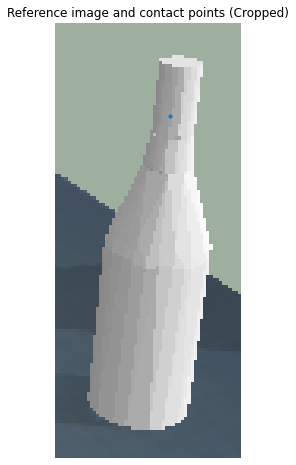

In [26]:
ref_img_mask = cv2.imread(ref_mask_path,cv2.IMREAD_GRAYSCALE)
ref_img_cropped, ref_cropbox = crop_image_from_mask(ref_img,ref_img_mask)
ref_pts_cropped = np.copy(ref_contact_pts)
ref_pts_cropped[:, 0] -= ref_cropbox[2]
ref_pts_cropped[:, 1] -= ref_cropbox[0]

%matplotlib inline
fig = plt.figure(figsize=(16, 8))
plt.imshow(ref_img_cropped)
plt.scatter(ref_pts_cropped[:,0],ref_pts_cropped[:,1],s = 10)
plt.axis('off')
plt.title('Reference image and contact points (Cropped)')
plt.show()


Query image:  0006
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[218.00363 178.11693]]


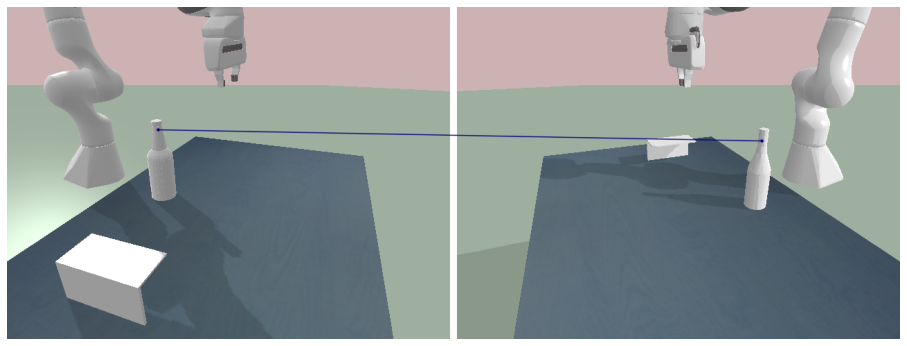

saved
Query image:  0002
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[222.53442 174.1    ]]


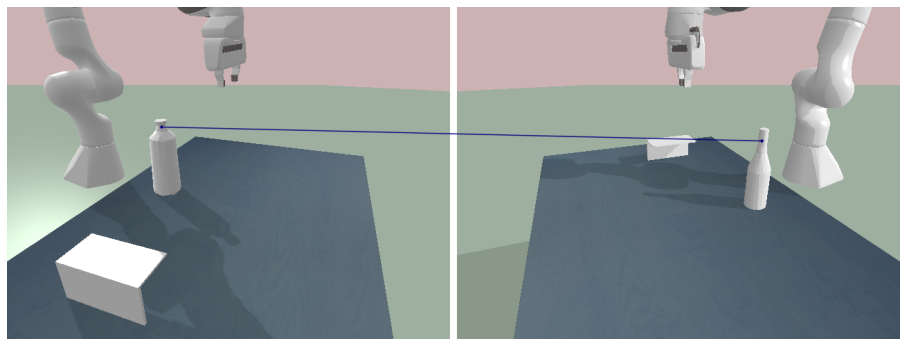

saved
Query image:  0001
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[220.3  173.65]]


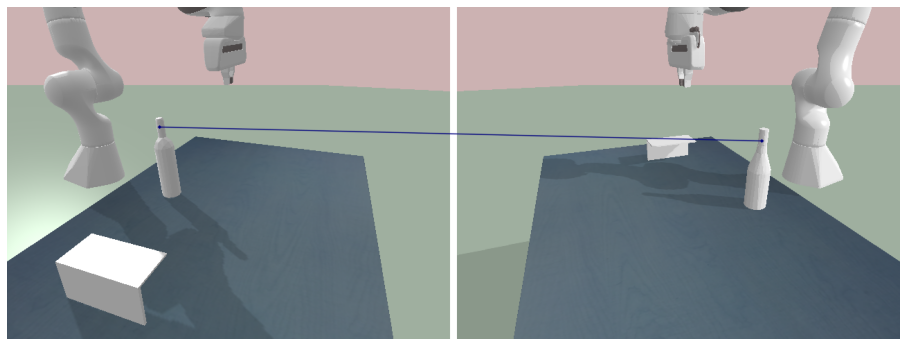

saved
Query image:  0015
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[224.47011 175.1    ]]


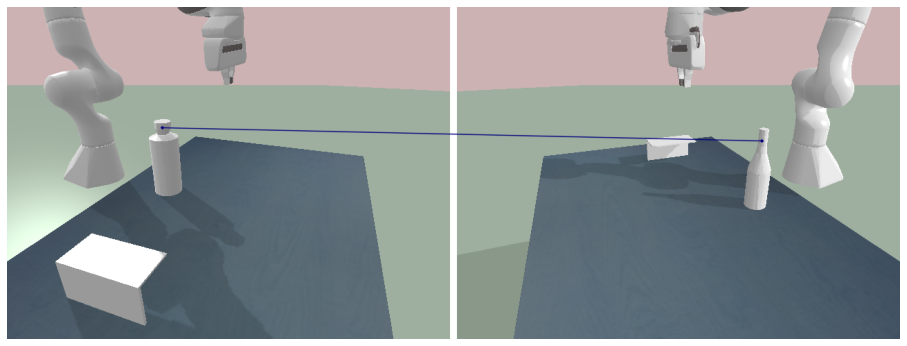

saved
Query image:  0025
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[237.07101 178.1    ]]


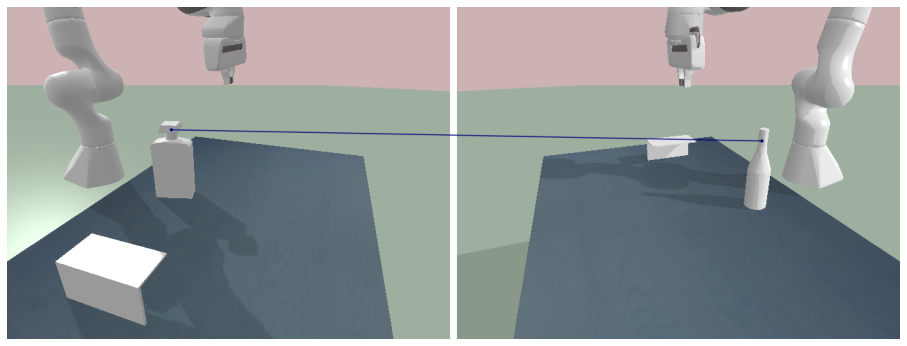

saved
Query image:  0021
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[243.3 199.1]]


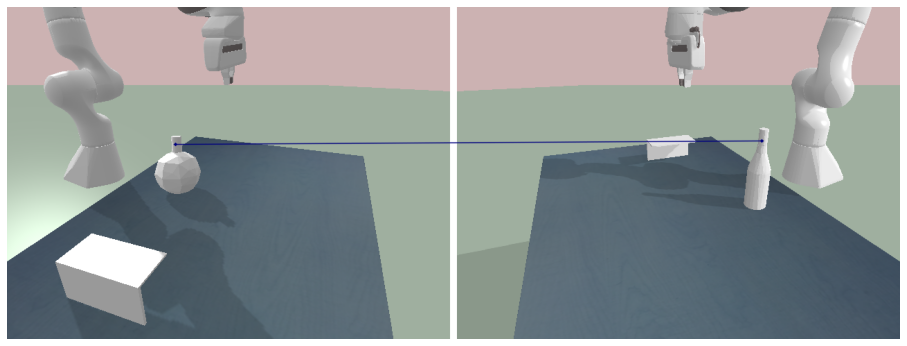

saved
Query image:  0000
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[222.1  182.65]]


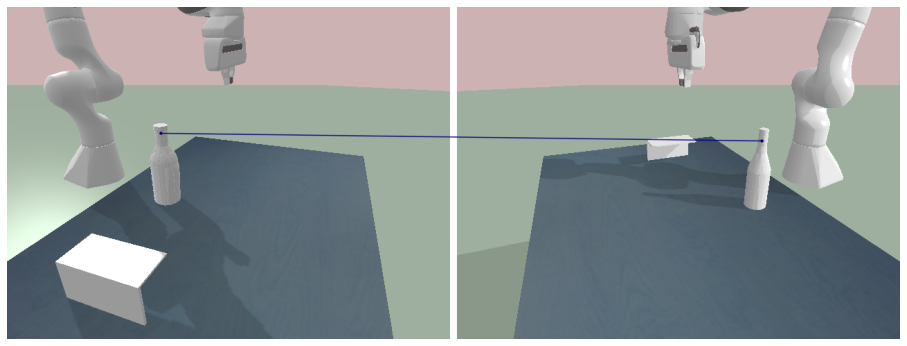

saved
Query image:  0018
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[232.25    181.02289]]


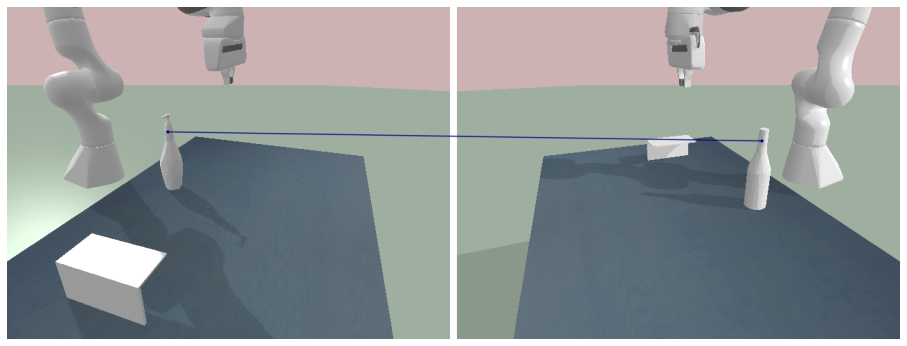

saved
Query image:  0010
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[272.2 163.1]]


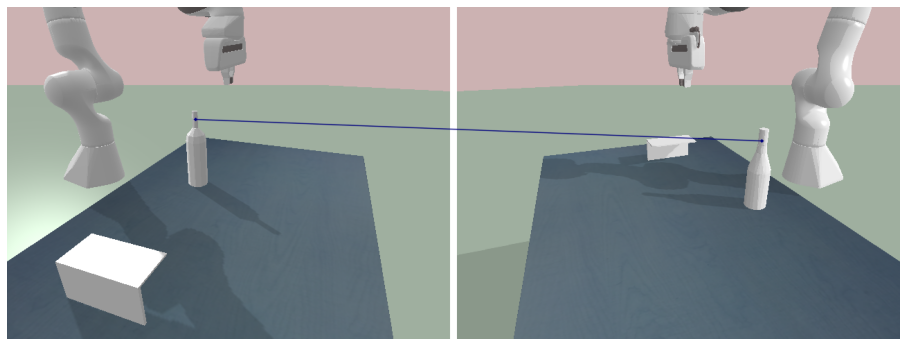

saved
Query image:  0009
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[223.225 169.1  ]]


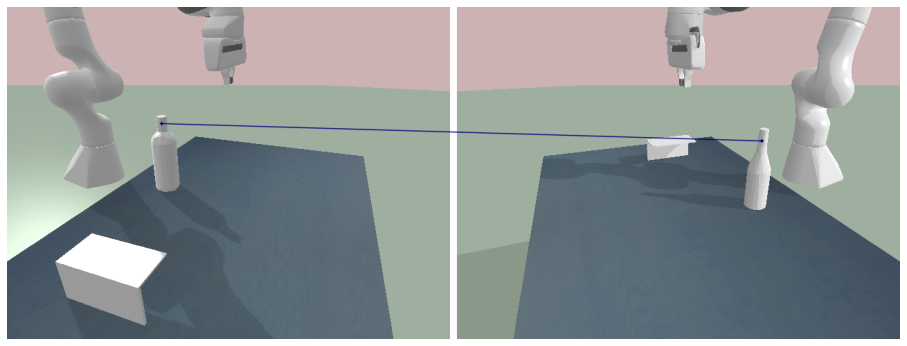

saved
Query image:  0003
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[237.35715 176.     ]]


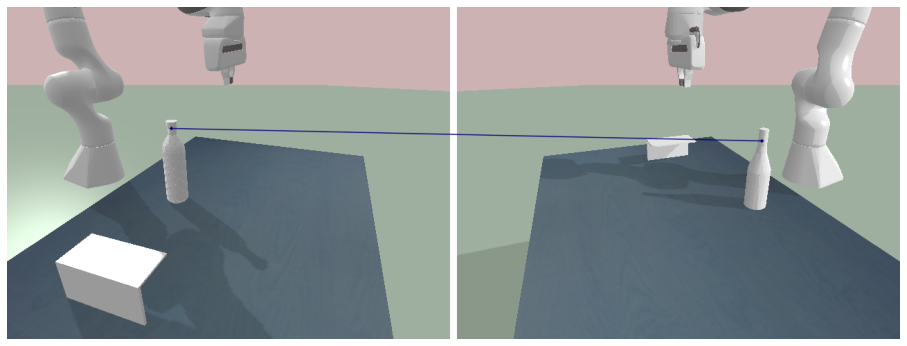

saved
Query image:  0024
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[210.94003 175.875  ]]


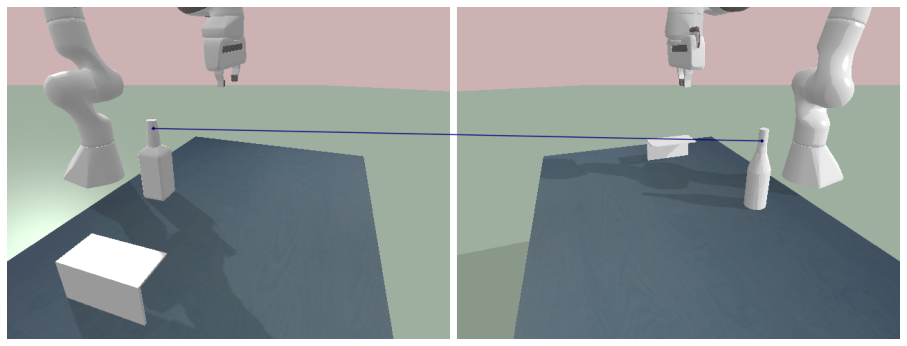

saved
Query image:  0013
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[237.67155 169.     ]]


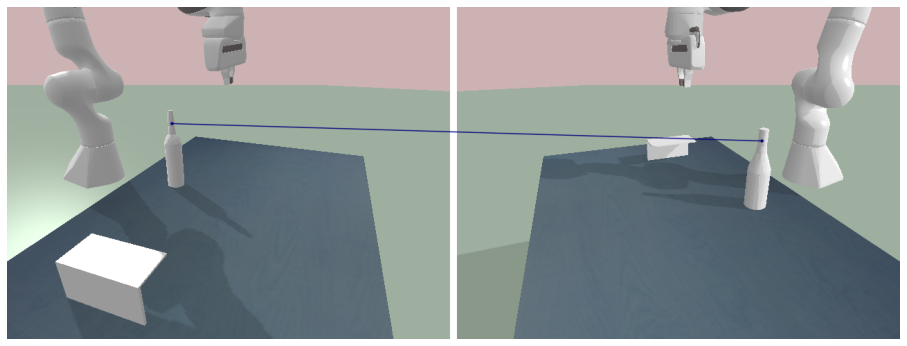

saved
Query image:  0005
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[199.25 174.8 ]]


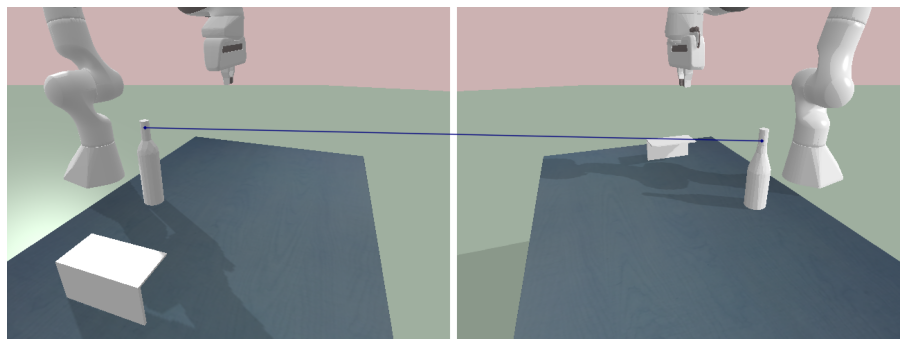

saved
Query image:  0012
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[251.2  173.65]]


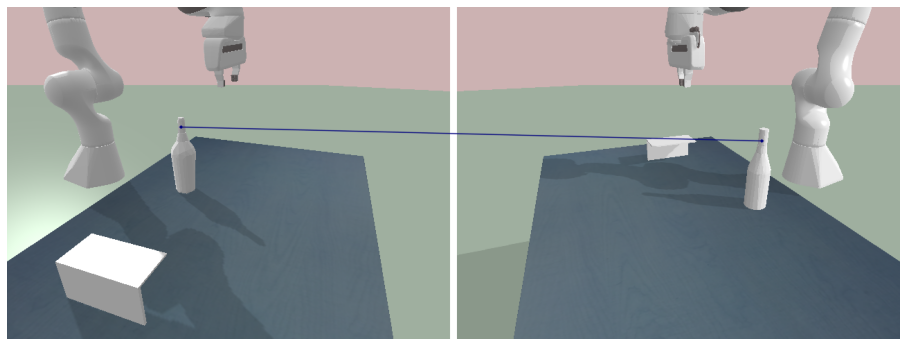

saved
Query image:  0019
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[219.14511 176.65   ]]


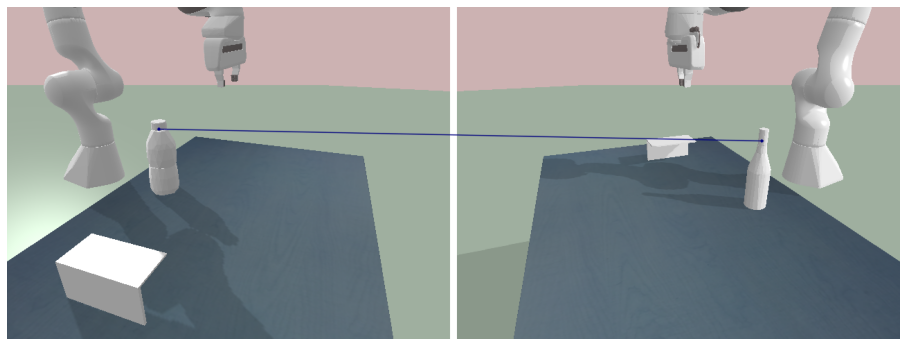

saved
Query image:  0016
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[237.35715 181.     ]]


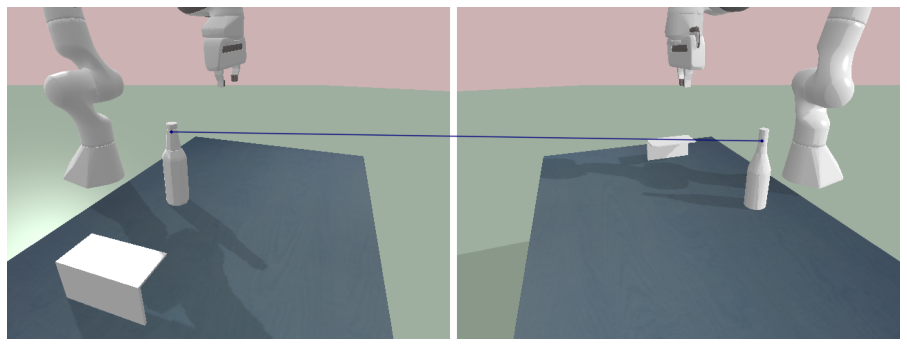

saved
Query image:  0011
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[221.2     180.50468]]


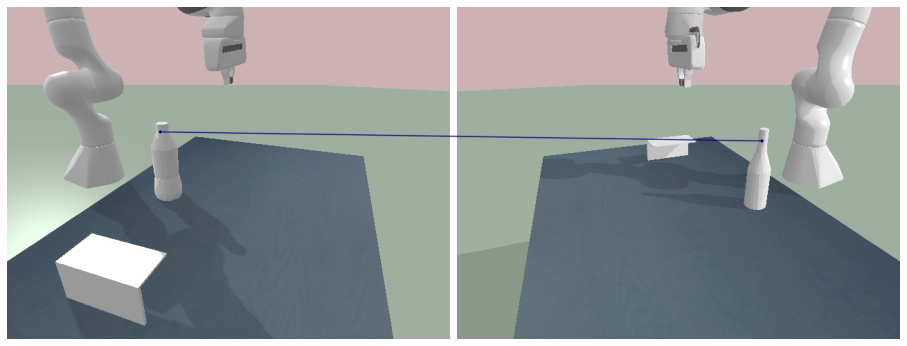

saved
Query image:  0007
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[244.20291 171.1    ]]


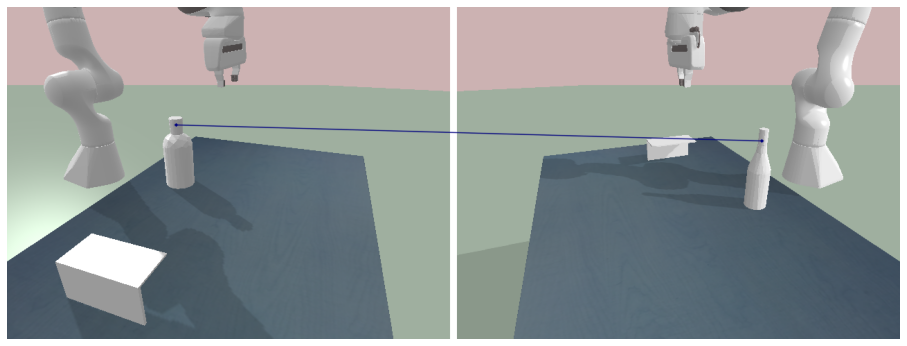

saved
Query image:  0020
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[241.36072 179.     ]]


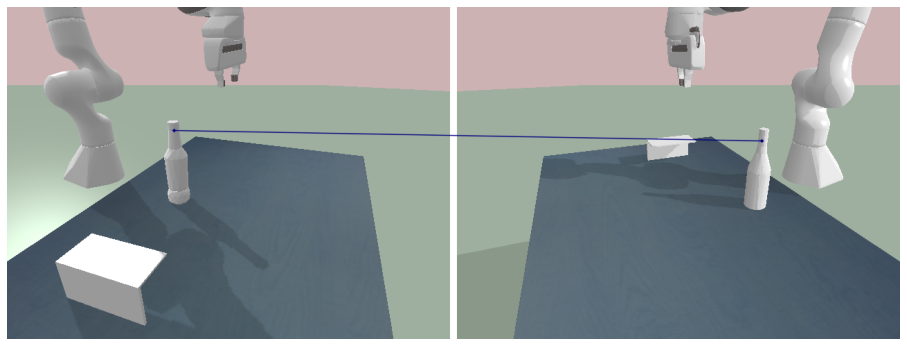

saved
Query image:  0022
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[227.3587  176.78107]]


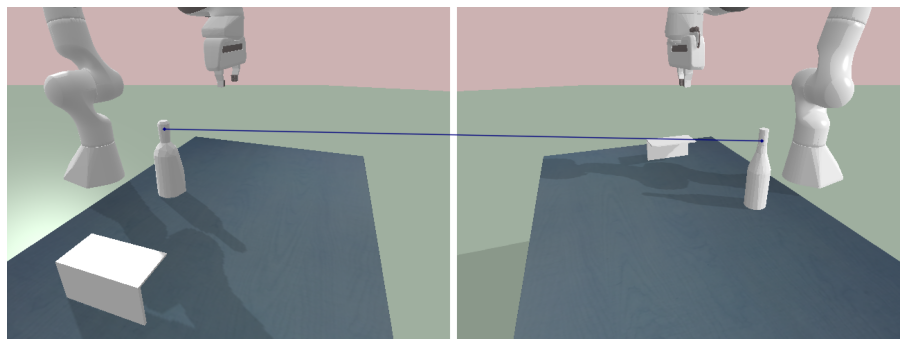

saved
Query image:  0017
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[223.93645 181.35   ]]


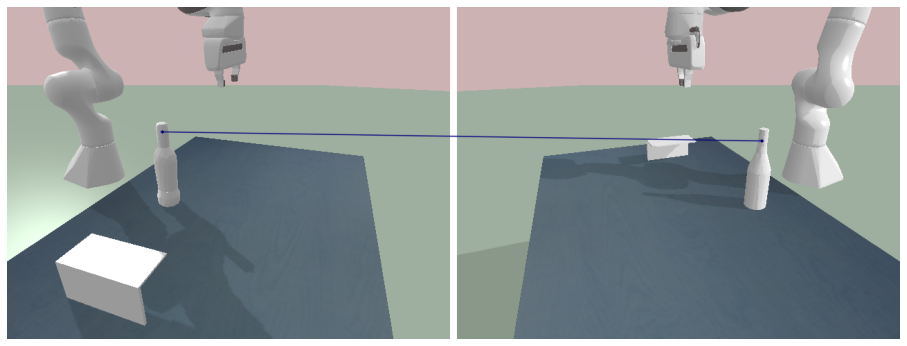

saved
Query image:  0014
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[227.45 234.75]]


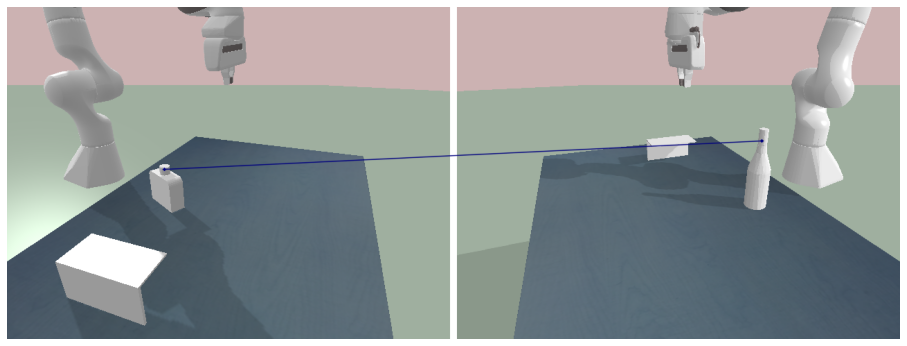

saved
Query image:  0023
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[231.4  180.65]]


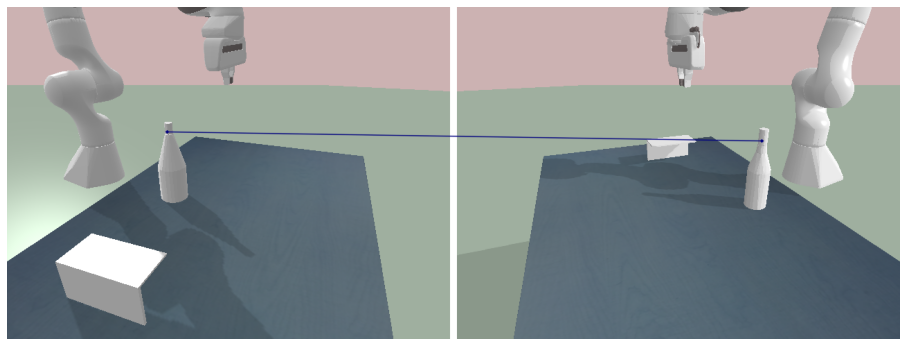

saved
Query image:  0004
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[245.      177.99834]]


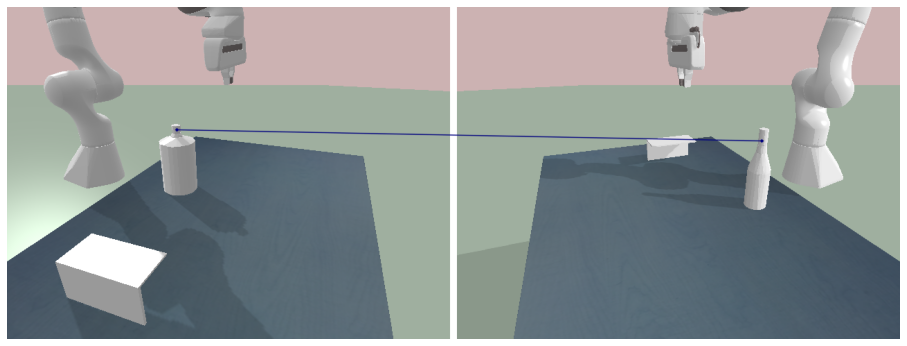

saved
Query image:  0026
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[206.07143 183.46875]]


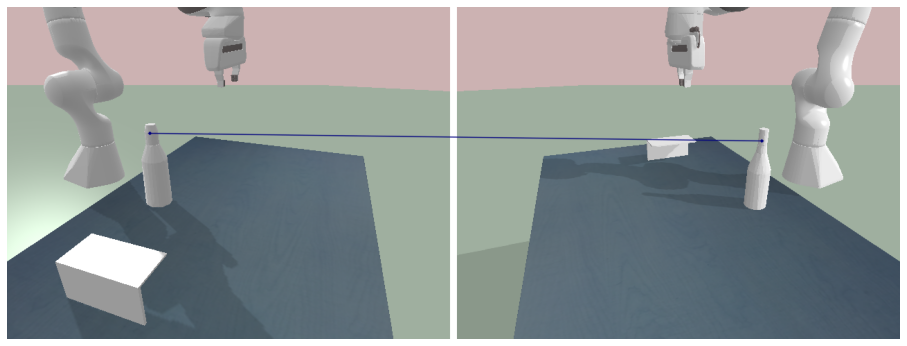

saved
Query image:  0008
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[245.40652 166.65   ]]


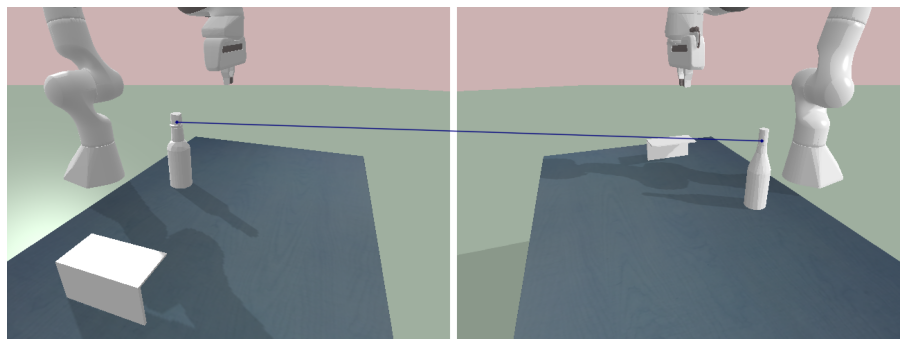

saved
Query image:  0027
Model: PWarpCSFNet_SS
Pre-trained-model: pfpascal
Query contact points [[221.94983 199.65   ]]


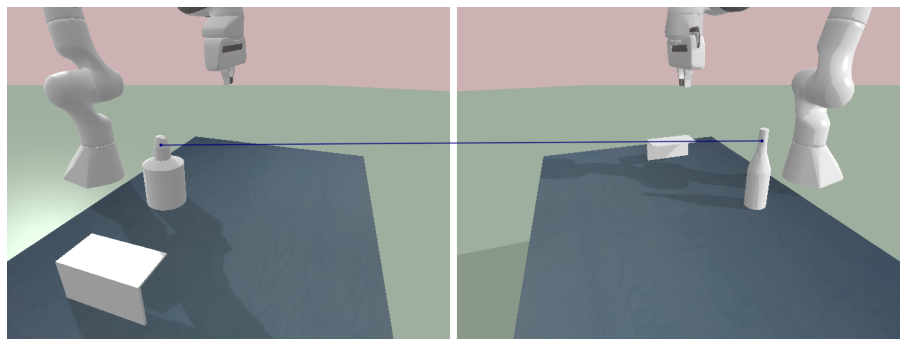

saved


In [27]:
split = 'eval'

query_img_list = glob.glob(os.path.join(root_path,split,cls,f'????.png'))

for query_img_path in query_img_list:
    query_img_name = os.path.basename(query_img_path).split('.')[0]
    query_mask_path = query_img_path.replace('.png','_mask.png')
    print('Query image: ',query_img_name)
    
    query_img_mask = cv2.imread(query_mask_path,cv2.IMREAD_GRAYSCALE)
    query_img = cv2.imread(query_img_path, 1)[:, :, ::- 1]
    query_img_cropped, query_cropbox = crop_image_from_mask(query_img,query_img_mask)
    
    _,query_pts_cropped = test_model_on_image_pair(args, query_img_cropped, ref_img_cropped,
                                                   contact_pixels = ref_pts_cropped,visualize = False)
    query_contact_pts = np.copy(query_pts_cropped)
    query_contact_pts[:, 0] += query_cropbox[2]
    query_contact_pts[:, 1] += query_cropbox[0]

    print('Query contact points',query_contact_pts)
    
#     fig = plt.figure(figsize=(16, 8))
#     plt.imshow(query_img)
#     plt.scatter(query_contact_pts[:,0],query_contact_pts[:,1],s = 10)
#     plt.axis('off')
#     plt.title('Query image and contact points')
#     plt.show()
    
    confidence_values = np.ones(query_pts_cropped.shape[0])
    import matplotlib.cm as cm
    color = cm.jet(confidence_values)
    
    matching = make_sparse_matching_plot(
        query_img, ref_img, query_contact_pts, ref_contact_pts, color, margin=10)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(matching)
    plt.axis('off')
    
    save_path = os.path.join(save_dir)
    plt.savefig(os.path.join(save_path,query_img_name + '_matching.png'))
    plt.show()
    
    query_info = dict()
    query_info['contact_pts'] = query_contact_pts
    save_path = os.path.join(save_dir,f'{query_img_name}_contact_pts.mat')
    sio.savemat(save_path, query_info)
    
    print('Saved!')
    
    